In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Simple repression

In [6]:
# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [8]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [9]:
n_NS = len(genome)
n_p = 4600
l_n_r = np.arange(0, 51, 2)
ep_wt = -5
er_wt = -15

fc_simrep = []
dr_simrep = []
wt_simrep = []
mut_simrep = []
for n_r in l_n_r:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                                     [rep_site],
                                     *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                     scaling_factor=10**4)

    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_simrep.append(fc)
    dr_simrep.append(np.max(norm_ct) - np.min(norm_ct))
    wt_simrep.append(norm_ct[0])
    mut_simrep.append(np.mean(norm_ct[1:]))

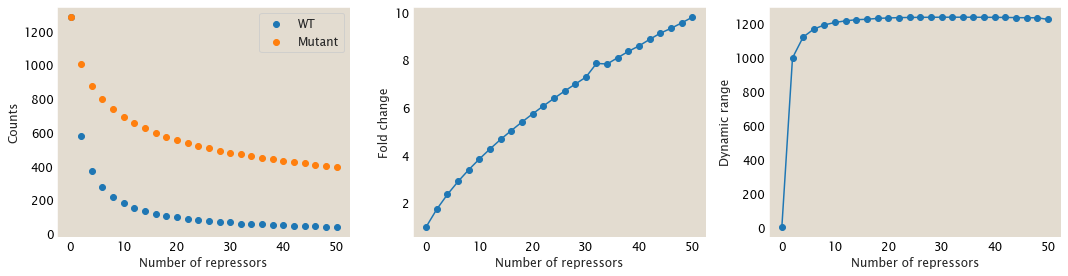

In [10]:
# plot fold change against number of repressors
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
ax1.scatter(l_n_r, wt_simrep, label='WT')
ax1.scatter(l_n_r, mut_simrep, label='Mutant')
ax1.set_xlabel('Number of repressors')
ax1.set_ylabel('Counts')
ax1.legend()

ax2.plot(l_n_r, fc_simrep)
ax2.scatter(l_n_r, fc_simrep)
ax2.set_xlabel('Number of repressors')
ax2.set_ylabel('Fold change')

ax3.plot(l_n_r, dr_simrep)
ax3.scatter(l_n_r, dr_simrep)
ax3.set_xlabel('Number of repressors')
ax3.set_ylabel('Dynamic range')
#ax3.set_yscale('log')

plt.tight_layout()

### Double repression

In [11]:
rep1_site = promoter[(115-70):(115-60)]
rep2_site = promoter[(115-50):(115-40)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

**Changing copy number**

In [12]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -10, -10
n_p, n_r2 = 4600, 15
l_n_r1 = np.arange(0, 50, 1)
e_int = -10

fc_doublerep_AND = []
dr_doublerep_AND = []
wt_doublerep_AND = []
mut_doublerep_AND = []
for n_r1 in l_n_r1:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        [rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**4)

    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doublerep_AND.append(fc)
    dr_doublerep_AND.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doublerep_AND.append(norm_ct[0])
    mut_doublerep_AND.append(np.mean(norm_ct[1:]))

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/1447461706.py:18: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])


In [13]:
fc_doublerep_OR = []
dr_doublerep_OR = []
wt_doublerep_OR = []
mut_doublerep_OR = []
for n_r1 in l_n_r1:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        [rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**4)

    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doublerep_OR.append(fc)
    dr_doublerep_OR.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doublerep_OR.append(norm_ct[0])
    mut_doublerep_OR.append(np.mean(norm_ct[1:]))

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/1993548884.py:12: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/1993548884.py:12: RuntimeWarning: invalid value encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])


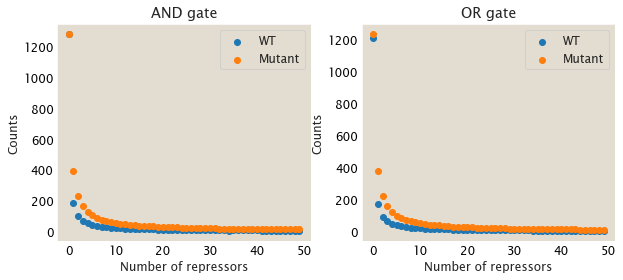

In [14]:
# plot wild type and mutant counts against number of repressors
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_n_r1, wt_doublerep_AND, label='WT')
ax1.scatter(l_n_r1, mut_doublerep_AND, label='Mutant')
ax1.set_xlabel('Number of repressors')
ax1.set_ylabel('Counts')
ax1.set_title('AND gate')
ax1.legend()

ax2.scatter(l_n_r1, wt_doublerep_OR, label='WT')
ax2.scatter(l_n_r1, mut_doublerep_OR, label='Mutant')
ax2.set_xlabel('Number of repressors')
ax2.set_ylabel('Counts')
ax2.set_title('OR gate')
ax2.legend()

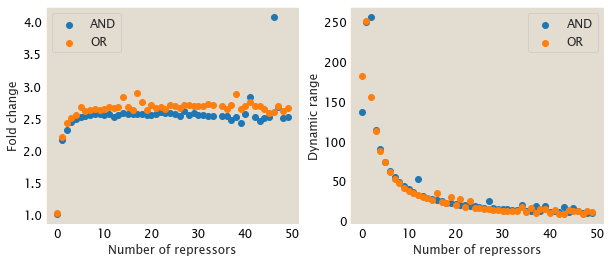

In [15]:
# plot fold change against number of repressors
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_n_r1, fc_doublerep_AND, label='AND')
ax1.scatter(l_n_r1, fc_doublerep_OR, label='OR')
ax1.set_xlabel('Number of repressors')
ax1.set_ylabel('Fold change')
ax1.legend()

ax2.scatter(l_n_r1, dr_doublerep_AND, label='AND')
ax2.scatter(l_n_r1, dr_doublerep_OR, label='OR')
ax2.set_xlabel('Number of repressors')
ax2.set_ylabel('Dynamic range')
ax2.legend();

**Changing interaction energy**

In [16]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -10, -10
n_p, n_r2 = 4600, 15
l_n_r1 = np.arange(0, 50, 1)
l_e_int = np.arange(-15, 10, 1)

fc_doublerep_AND2 = []
dr_doublerep_AND2 = []
wt_doublerep_AND2 = []
mut_doublerep_AND2 = []
for e_int in l_e_int:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        [rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                        scaling_factor=10**4)

    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doublerep_AND2.append(fc)
    dr_doublerep_AND2.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doublerep_AND2.append(norm_ct[0])
    mut_doublerep_AND2.append(np.mean(norm_ct[1:]))

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/2702669366.py:18: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/2702669366.py:18: RuntimeWarning: invalid value encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/2702669366.py:18: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/2702669366.py:18: RuntimeWarning: invalid value encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/2702669366.py:18: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/2702669366.py:18: RuntimeWa

In [17]:
fc_doublerep_OR2 = []
dr_doublerep_OR2 = []
wt_doublerep_OR2 = []
mut_doublerep_OR2 = []
for e_int in l_e_int:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                        [rep1_site, rep2_site],
                        *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'OR'],
                        scaling_factor=10**4)

    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doublerep_OR2.append(fc)
    dr_doublerep_OR2.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doublerep_OR2.append(norm_ct[0])
    mut_doublerep_OR2.append(np.mean(norm_ct[1:]))

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/448585113.py:12: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/448585113.py:12: RuntimeWarning: invalid value encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/448585113.py:12: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/448585113.py:12: RuntimeWarning: invalid value encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])


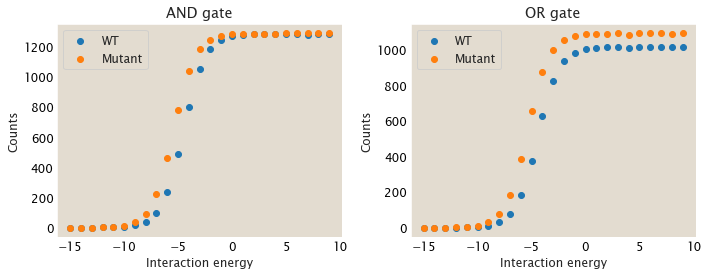

In [18]:
# plot wild type and mutant counts against number of repressors
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_e_int, wt_doublerep_AND2, label='WT')
ax1.scatter(l_e_int, mut_doublerep_AND2, label='Mutant')
ax1.set_xlabel('Interaction energy')
ax1.set_ylabel('Counts')
ax1.set_title('AND gate')
ax1.legend()

ax2.scatter(l_e_int, wt_doublerep_OR2, label='WT')
ax2.scatter(l_e_int, mut_doublerep_OR2, label='Mutant')
ax2.set_xlabel('Interaction energy')
ax2.set_ylabel('Counts')
ax2.set_title('OR gate')
ax2.legend()

plt.tight_layout()

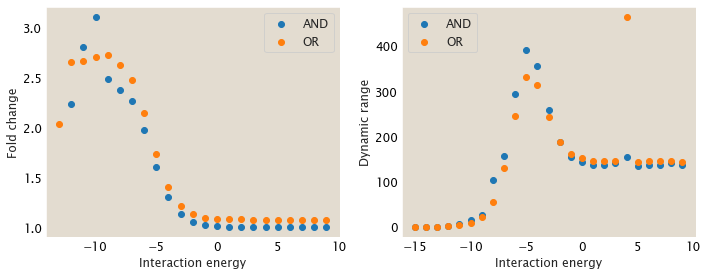

In [19]:
# plot fold change and dynamic range against number of repressors
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_e_int, fc_doublerep_AND2, label='AND')
ax1.scatter(l_e_int, fc_doublerep_OR2, label='OR')
ax1.set_xlabel('Interaction energy')
ax1.set_ylabel('Fold change')
ax1.legend()

ax2.scatter(l_e_int, dr_doublerep_AND2, label='AND')
ax2.scatter(l_e_int, dr_doublerep_OR2, label='OR')
ax2.set_xlabel('Interaction energy')
ax2.set_ylabel('Dynamic range')
ax2.legend()

plt.tight_layout()

### Simple activation

In [20]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [21]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [22]:
n_NS = len(genome)
n_p = 4600
ep_wt = -7
ea_wt = -15
e_ap = -10
l_n_a = np.arange(0, 51)

fc_simact = []
dr_simact = []
wt_simact = []
mut_simact = []
for n_a in l_n_a:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site],
                                    [crp_site],
                                     *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap],
                                     scaling_factor=10**4)

    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_simact.append(fc)
    dr_simact.append(np.max(norm_ct) - np.min(norm_ct))
    wt_simact.append(norm_ct[0])
    mut_simact.append(np.mean(norm_ct[1:]))

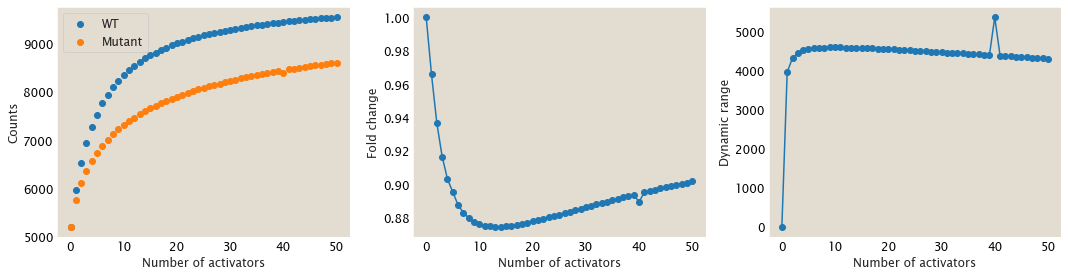

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes

ax1.scatter(l_n_a, wt_simact, label='WT')
ax1.scatter(l_n_a, mut_simact, label='Mutant')
ax1.set_xlabel('Number of activators')
ax1.set_ylabel('Counts')
ax1.legend()

ax2.plot(l_n_a, fc_simact)
ax2.scatter(l_n_a, fc_simact)
ax2.set_xlabel('Number of activators')
ax2.set_ylabel('Fold change')

ax3.plot(l_n_a, dr_simact)
ax3.scatter(l_n_a, dr_simact)
ax3.set_xlabel('Number of activators')
ax3.set_ylabel('Dynamic range')

plt.tight_layout()

### Double activation

In [24]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

In [25]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a2 = 4600, 50
l_n_a1 = np.arange(0, 1000, 1)

fc_doubleact_AND = []
dr_doubleact_AND = []
wt_doubleact_AND = []
mut_doubleact_AND = []
for n_a1 in l_n_a1:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**4)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doubleact_AND.append(fc)
    dr_doubleact_AND.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doubleact_AND.append(norm_ct[0])
    mut_doubleact_AND.append(np.mean(norm_ct[1:]))

In [26]:
fc_doubleact_OR = []
dr_doubleact_OR = []
wt_doubleact_OR = []
mut_doubleact_OR = []
for n_a1 in l_n_a1:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=10**4)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doubleact_OR.append(fc)
    dr_doubleact_OR.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doubleact_OR.append(norm_ct[0])
    mut_doubleact_OR.append(np.mean(norm_ct[1:]))

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_54621/3760096990.py:10: RuntimeWarning: divide by zero encountered in true_divide
  fc = np.mean(norm_ct[1:] / norm_ct[0])


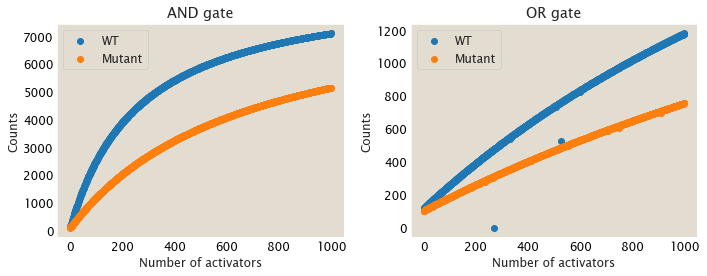

In [29]:
# plot wild type and mutant counts against number of activators
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_n_a1, wt_doubleact_AND, label='WT')
ax1.scatter(l_n_a1, mut_doubleact_AND, label='Mutant')
ax1.set_xlabel('Number of activators')
ax1.set_ylabel('Counts')
ax1.set_title('AND gate')
ax1.legend()

ax2.scatter(l_n_a1, wt_doubleact_OR, label='WT')
ax2.scatter(l_n_a1, mut_doubleact_OR, label='Mutant')
ax2.set_xlabel('Number of activators')
ax2.set_ylabel('Counts')
ax2.set_title('OR gate')
ax2.legend()

plt.tight_layout()

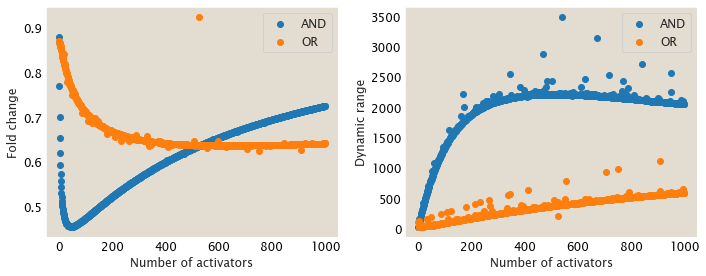

In [30]:
# plot fold change and dynamic range against number of activators
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_n_a1, fc_doubleact_AND, label='AND')
ax1.scatter(l_n_a1, fc_doubleact_OR, label='OR')
ax1.set_xlabel('Number of activators')
ax1.set_ylabel('Fold change')
ax1.legend()

ax2.scatter(l_n_a1, dr_doubleact_AND, label='AND')
ax2.scatter(l_n_a1, dr_doubleact_OR, label='OR')
ax2.set_xlabel('Number of activators')
ax2.set_ylabel('Dynamic range')
ax2.legend()

plt.tight_layout()

In [31]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2 = -4, -4
n_p, n_a1, n_a2 = 4600, 50, 50
l_e_int_a1a2 = np.arange(-20, 10, 1)

fc_doubleact_AND2 = []
dr_doubleact_AND2 = []
wt_doubleact_AND2 = []
mut_doubleact_AND2 = []
for e_int_a1a2 in l_e_int_a1a2:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doubleact_AND2.append(fc)
    dr_doubleact_AND2.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doubleact_AND2.append(norm_ct[0])
    mut_doubleact_AND2.append(np.mean(norm_ct[1:]))

In [32]:
fc_doubleact_OR2 = []
dr_doubleact_OR2 = []
wt_doubleact_OR2 = []
mut_doubleact_OR2 = []
for e_int_a1a2 in l_e_int_a1a2:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doubleact_OR2.append(fc)
    dr_doubleact_OR2.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doubleact_OR2.append(norm_ct[0])
    mut_doubleact_OR2.append(np.mean(norm_ct[1:]))

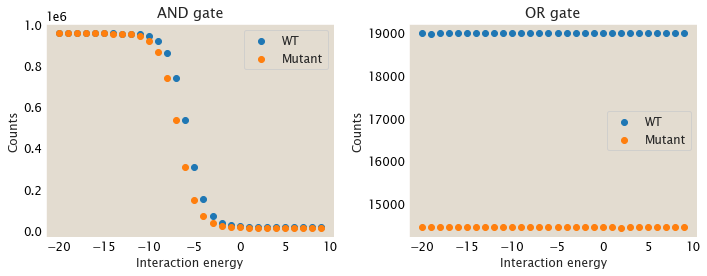

In [33]:
# plot wild type and mutant counts against interaction energy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_e_int_a1a2, wt_doubleact_AND2, label='WT')
ax1.scatter(l_e_int_a1a2, mut_doubleact_AND2, label='Mutant')
ax1.set_xlabel('Interaction energy')
ax1.set_ylabel('Counts')
ax1.set_title('AND gate')
ax1.legend()

ax2.scatter(l_e_int_a1a2, wt_doubleact_OR2, label='WT')
ax2.scatter(l_e_int_a1a2, mut_doubleact_OR2, label='Mutant')
ax2.set_xlabel('Interaction energy')
ax2.set_ylabel('Counts')
ax2.set_title('OR gate')
ax2.legend()

plt.tight_layout()

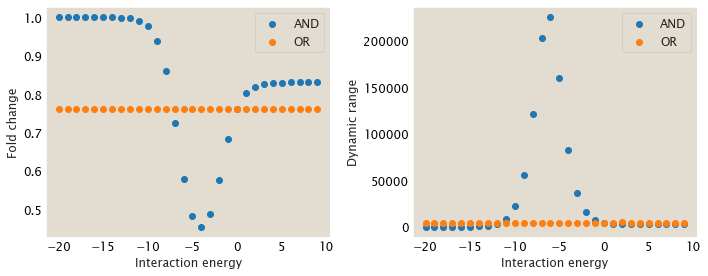

In [34]:
# plot fold change and dynamic range against interaction energy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_e_int_a1a2, fc_doubleact_AND2, label='AND')
ax1.scatter(l_e_int_a1a2, fc_doubleact_OR2, label='OR')
ax1.set_xlabel('Interaction energy')
ax1.set_ylabel('Fold change')
ax1.legend()

ax2.scatter(l_e_int_a1a2, dr_doubleact_AND2, label='AND')
ax2.scatter(l_e_int_a1a2, dr_doubleact_OR2, label='OR')
ax2.set_xlabel('Interaction energy')
ax2.set_ylabel('Dynamic range')
ax2.legend()

plt.tight_layout()